<div align="center"><h3>HW2, Part2</h3></div>
<div align="center"><h5>Mohammadreza Ghofrani, 400131076</h5></div>

In [1]:
import os
# To disable gpu warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from hazm import *
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt

# Constants

In [3]:
PAD = 0
UNK = 1

# Utils

In [4]:
def sentence_reader(file_path):
    def _reader():
        consecutive_newline_cnt = 0
        with open(file_path, 'r', encoding='utf-8') as f:
            while True:
                sent_words = list()
                sent_pos = list()
                while True:
                    line = f.readline()
                    if line == '\n' or \
                        line == '':
                        consecutive_newline_cnt += 1
                        break
                    word, pos = line.split()
                    sent_words.append(word)
                    sent_pos.append(pos)
                    consecutive_newline_cnt = 0

                if consecutive_newline_cnt == 2:
                    break
                yield sent_words, sent_pos
    return _reader

# Part 1: Training BiLSTM Model

## Extract Vocab and POS

In [5]:
def extract_vocab_and_pos():
    vocab, tags = set(), set()
    sentence_rd = sentence_reader('../data/UPC_2016_train.txt')
    for sentence in sentence_rd():
        _word, _tag = sentence
        vocab = vocab.union(set(_word))
        tags = tags.union(set(_tag))
    vocab, tags = list(vocab), list(tags)
    vocab = ['<unk>'] + vocab
    return vocab, tags

vocab, pos_tag = extract_vocab_and_pos()

In [6]:
def encoder(dictionary):
    def _encoder(word_list):
        return [dictionary.get(w, UNK) for w in word_list]
    return _encoder

word_encoder = encoder({v:i for i, v in enumerate(vocab)})
pos_encoder = encoder({v:i for i, v in enumerate(pos_tag)})

In [7]:
def decoder(dictionary):
    def _decoder(wordid_list):
        return [dictionary.get(w, UNK) for w in wordid_list]
    return _decoder

pos_decoder = decoder({i:v for i, v in enumerate(pos_tag)})

## Preparing data

In [8]:
sentence_rd = sentence_reader('../data/UPC_2016_train.txt')
sentence_lengths = sorted([len(sent[0]) for sent in sentence_rd()])
px.histogram(sentence_lengths)

In [9]:
def dataset_generator(file_path):
    X, y = list(), list()
    sentence_rd = sentence_reader(file_path)
    for sent in sentence_rd():
        words, pos = sent
        if len(words) > 100:
            continue
        X.append(word_encoder(words))
        y.append(pos_encoder(pos))
    return \
        tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=100), \
        tf.keras.preprocessing.sequence.pad_sequences(y, padding='post', maxlen=100)

In [10]:
x_train, y_train = dataset_generator('../data/UPC_2016_train.txt')
x_val, y_val = dataset_generator('../data/UPC_2016_val.txt')
x_test, y_test = dataset_generator('../data/UPC_2016_test.txt')

## Preparing Embedding Layer

In [11]:
embeddings_index = {}
with open('../data/glove.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 240548 word vectors.


In [12]:
num_tokens = len(vocab) + 1 # One extra for OOV and padding
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 28522 words (8524 misses)


## Model

In [13]:
# Model Layers
input_layer = tf.keras.layers.Input((100,))
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True)
lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256, return_sequences=True))
time_dist_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(pos_tag)))
activation_layer = tf.keras.layers.Activation('softmax')

# Model data flow
embed_out = embedding_layer(input_layer)
lstm_out = lstm_layer(embed_out)
time_dist_out = time_dist_layer(lstm_out)
preds = activation_layer(time_dist_out)

model = tf.keras.Model(input_layer, preds)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train, validation_data=(x_train, y_train), batch_size=128, epochs=20)

Epoch 1/20
161/161 [==============================] - 12s 40ms/step - loss: 0.3485 - acc: 0.6446 - val_loss: 0.2111 - val_acc: 0.7623
Epoch 2/20
161/161 [==============================] - 5s 30ms/step - loss: 0.1841 - acc: 0.7947 - val_loss: 0.1624 - val_acc: 0.8159
Epoch 3/20
161/161 [==============================] - 5s 30ms/step - loss: 0.1482 - acc: 0.8350 - val_loss: 0.1345 - val_acc: 0.8544
Epoch 4/20
161/161 [==============================] - 5s 30ms/step - loss: 0.1252 - acc: 0.8629 - val_loss: 0.1166 - val_acc: 0.8747
Epoch 5/20
161/161 [==============================] - 5s 30ms/step - loss: 0.1090 - acc: 0.8823 - val_loss: 0.1009 - val_acc: 0.8925
Epoch 6/20
161/161 [==============================] - 5s 30ms/step - loss: 0.0970 - acc: 0.8960 - val_loss: 0.0920 - val_acc: 0.9016
Epoch 7/20
161/161 [==============================] - 5s 30ms/step - loss: 0.0879 - acc: 0.9062 - val_loss: 0.0822 - val_acc: 0.9134
Epoch 8/20
161/161 [==============================] - 5s 30ms/step -

In [14]:
model.evaluate(x_test, y_test)

416/416 [==============================] - 2s 5ms/step - loss: 0.0627 - acc: 0.9351


[0.06271669268608093, 0.9350605010986328]

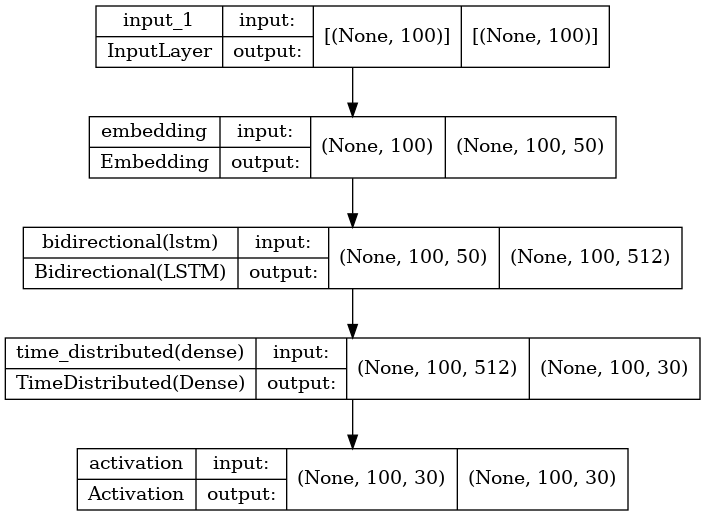

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Step 2: Evaluation

In [16]:
_y_test_pred = model.predict(x_test)
y_test_pred = np.zeros((len(_y_test_pred), len(_y_test_pred[0])))

for i, inst in enumerate(_y_test_pred):
    for j, y in enumerate(inst):
        y_test_pred[i][j] = np.argmax(y)

## loss & acc on train and validation

In [17]:
hist = history.history
epochs = list(range(len(hist['loss'])))

In [18]:
fig = go.Figure(
    data=[
        go.Scatter(x=epochs,
                   y=hist['loss'],
                   name='train'),
        go.Scatter(x=epochs,
                   y=hist['val_loss'],
                   name='validation')
    ])

fig.update_layout({
    'title': {
        'x': 0.5,
        'text': 'Loss vs Epochs',
    }
})

fig.show()
fig.write_image("../images/loss_epoch.png")

In [19]:
fig = go.Figure(
    data=[
        go.Scatter(x=epochs,
                   y=hist['acc'],
                   name='train'),
        go.Scatter(x=epochs,
                   y=hist['val_acc'],
                   name='validation')
    ])

fig.update_layout({
    'title': {
        'x': 0.5,
        'text': 'Accuracy vs Epochs',
    }
})

fig.show()
fig.write_image('../images/acc_epoch.png')

## Confusion Matrix

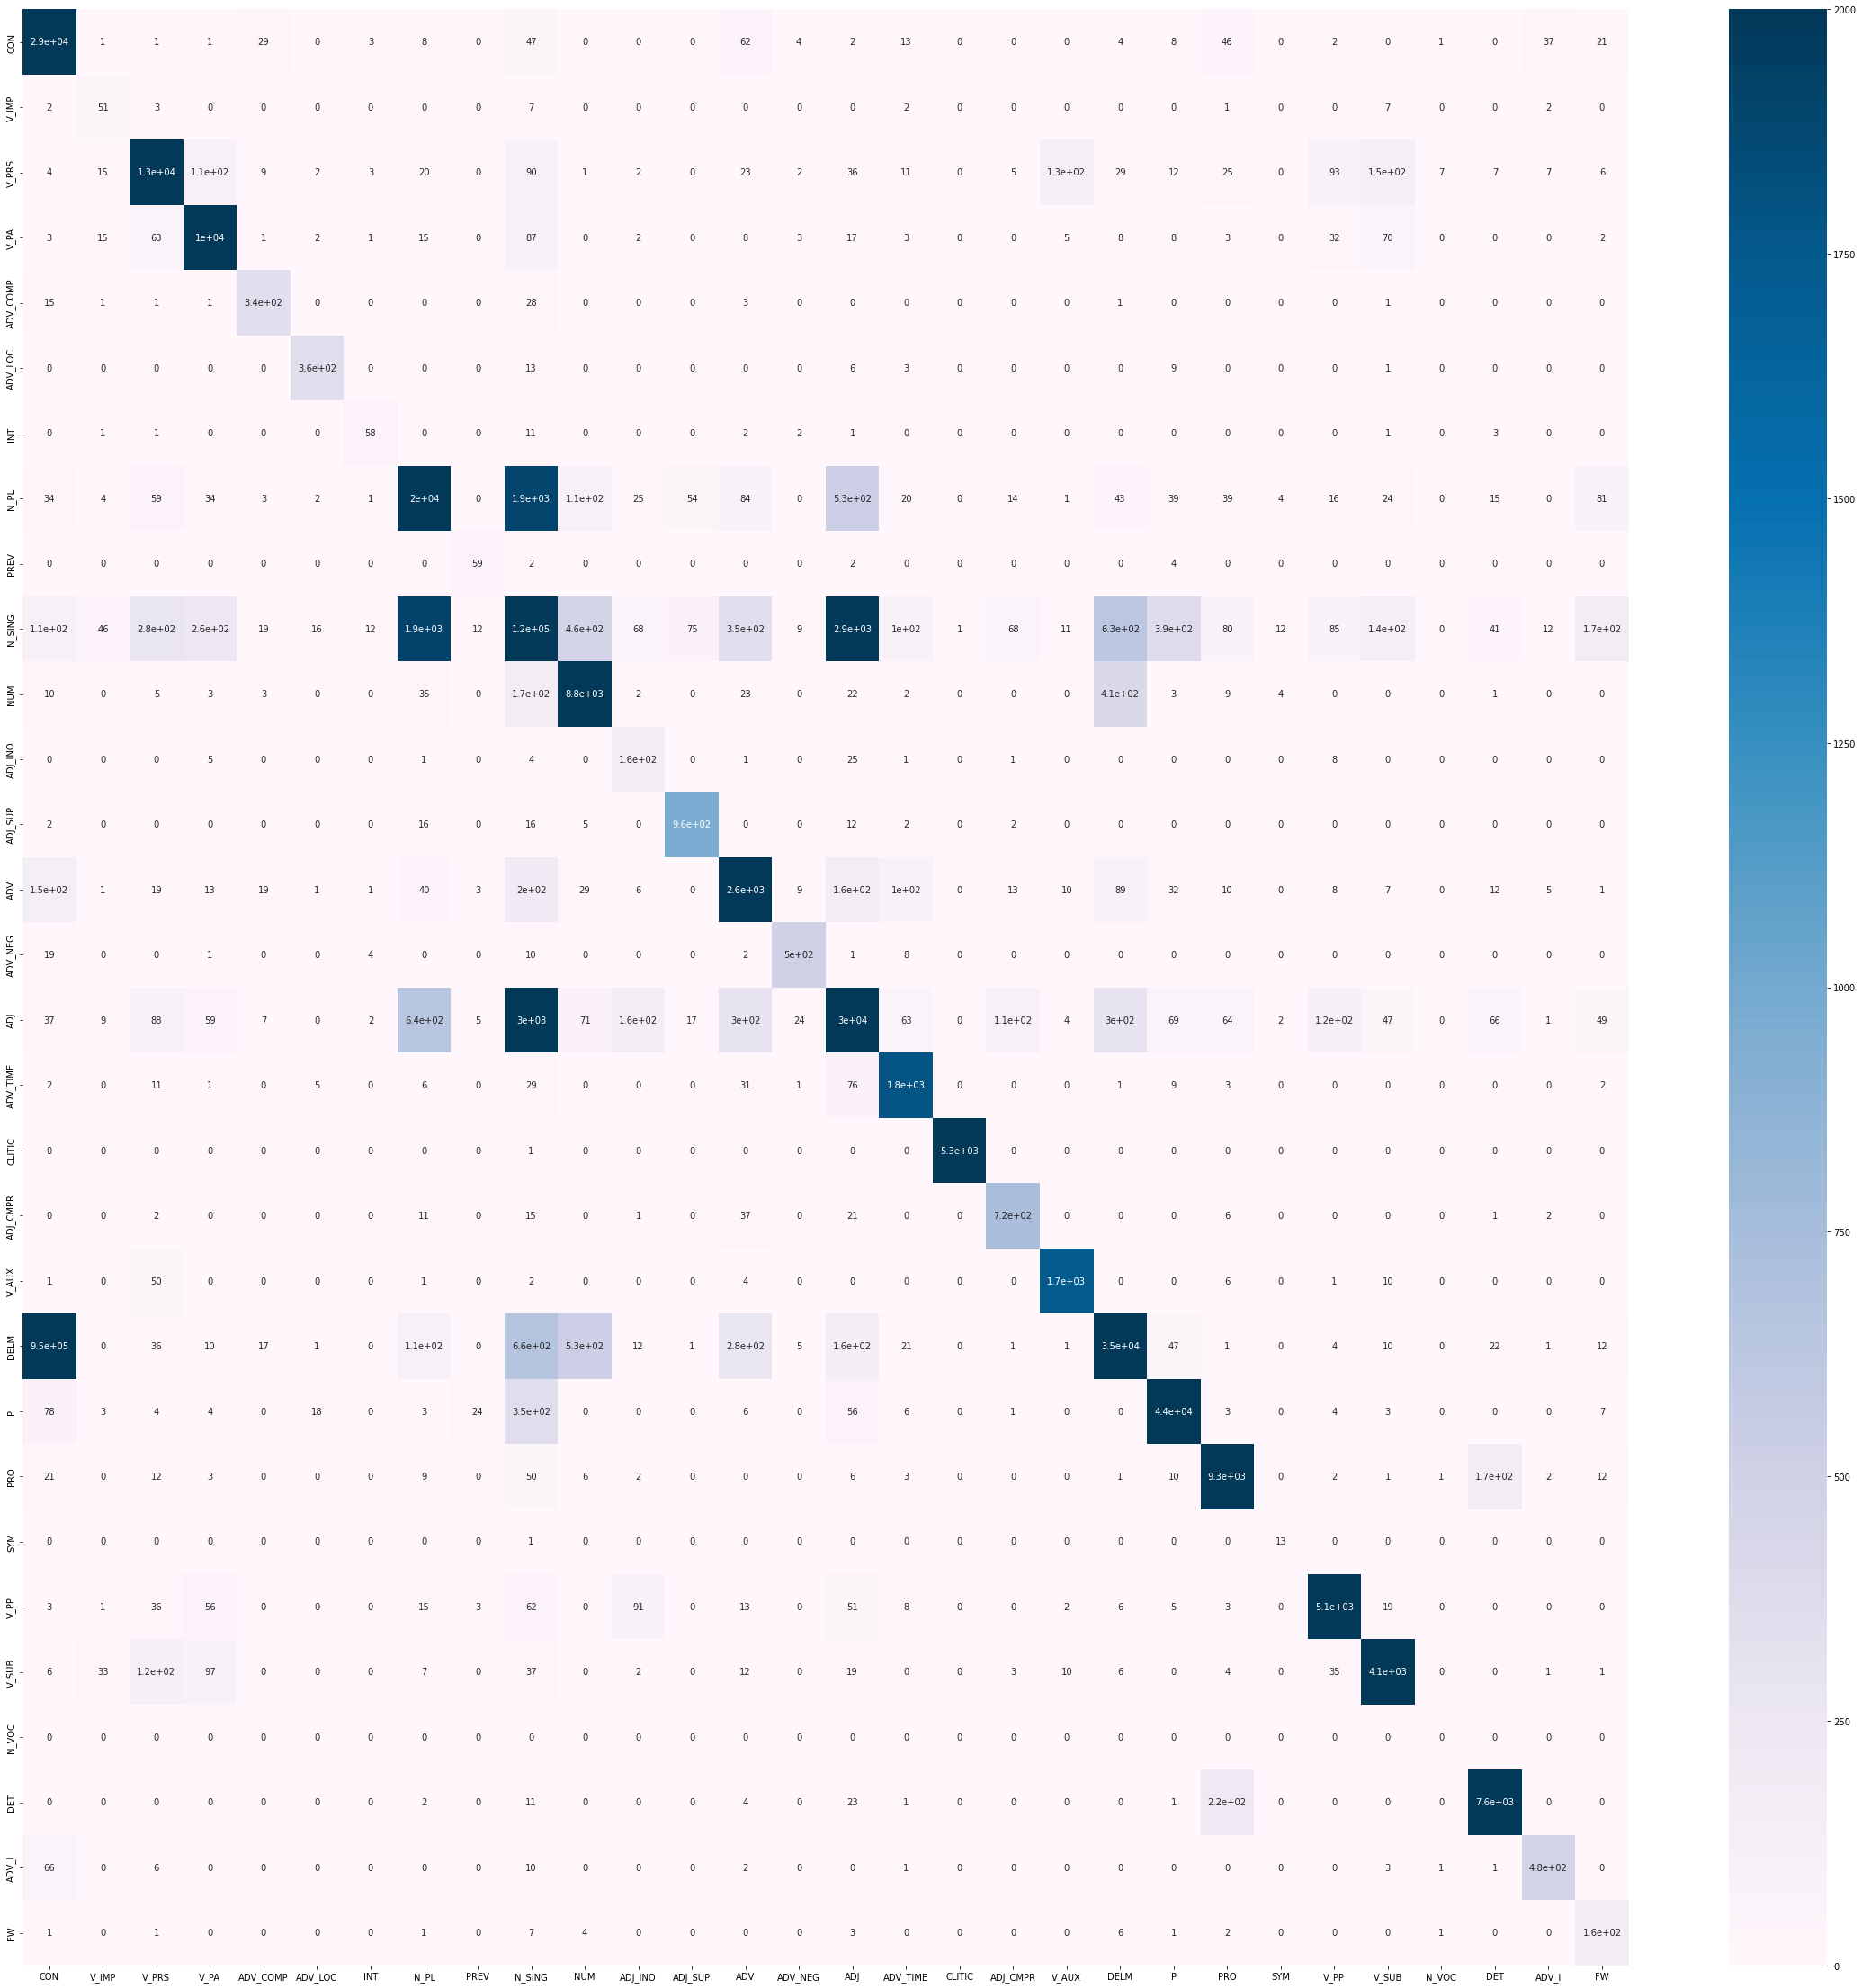

In [20]:
confusion_matrix = {pos:{pos:0 for pos in pos_tag} for pos in pos_tag}
for test_pred, test_tr in zip(y_test_pred, y_test):
    pos_pred = pos_decoder(test_pred)
    pos_tr = pos_decoder(test_tr)
    for _pos_pred, _pos_tr in zip(pos_pred, pos_tr):
        confusion_matrix[_pos_tr][_pos_pred] += 1

confusion_matrix = pd.DataFrame(confusion_matrix)
plt.figure(figsize = (40, 40))
conf_mat = sn.heatmap(confusion_matrix, annot=True, vmax=2000, cmap='PuBu')
fig = conf_mat.get_figure()
fig.savefig("../images/confusion_matrix.png")

## Accuracy using Eq. 1

In [42]:
pos = 'CON'
true_positive_count = confusion_matrix[pos][pos]
true_negative_count = confusion_matrix.drop(pos, axis=0, inplace=False).drop(pos, axis=1, inplace=False).to_numpy().sum()

In [40]:
print('Reporting Accuracy')
total_count = confusion_matrix.to_numpy().sum()
for pos in pos_tag:
    true_positive_count = confusion_matrix[pos][pos]
    true_negative_count = confusion_matrix.drop(pos, axis=0, inplace=False).drop(pos, axis=1, inplace=False).to_numpy().sum()
    print(f'\t{pos}: {(true_positive_count+true_negative_count)/total_count:.2f}')

Reporting Accuracy
	CON: 0.28
	V_IMP: 1.00
	V_PRS: 1.00
	V_PA: 1.00
	ADV_COMP: 1.00
	ADV_LOC: 1.00
	INT: 1.00
	N_PL: 1.00
	PREV: 1.00
	N_SING: 0.99
	NUM: 1.00
	ADJ_INO: 1.00
	ADJ_SUP: 1.00
	ADV: 1.00
	ADV_NEG: 1.00
	ADJ: 0.99
	ADV_TIME: 1.00
	CLITIC: 1.00
	ADJ_CMPR: 1.00
	V_AUX: 1.00
	DELM: 0.28
	P: 1.00
	PRO: 1.00
	SYM: 1.00
	V_PP: 1.00
	V_SUB: 1.00
	N_VOC: 1.00
	DET: 1.00
	ADV_I: 1.00
	FW: 1.00


In [21]:
pos_acc = {pos: 0 for pos in pos_tag}
pos_cnt = {pos: 0 for pos in pos_tag}


for _yt, _ytp in zip(y_test, y_test_pred):
    pos_yt, pos_ytp = pos_decoder(_yt), pos_decoder(_ytp)
    for y, yp in zip(pos_yt, pos_ytp):
        if y == yp:
            pos_acc[y] += 1
        pos_cnt[y] += 1

print('POS Accuracy:')
for pos in pos_tag:
    if pos_cnt[pos] == 0:
        continue
    print(f'\t{pos}:{pos_acc[pos]/pos_cnt[pos]:.2f}')

POS Accuracy:
	CON:0.03
	V_IMP:0.28
	V_PRS:0.94
	V_PA:0.94
	ADV_COMP:0.76
	ADV_LOC:0.88
	INT:0.68
	N_PL:0.88
	PREV:0.56
	N_SING:0.95
	NUM:0.88
	ADJ_INO:0.30
	ADJ_SUP:0.87
	ADV:0.68
	ADV_NEG:0.89
	ADJ:0.88
	ADV_TIME:0.83
	CLITIC:1.00
	ADJ_CMPR:0.76
	V_AUX:0.91
	DELM:0.96
	P:0.99
	PRO:0.95
	SYM:0.37
	V_PP:0.93
	V_SUB:0.89
	N_VOC:0.00
	DET:0.96
	ADV_I:0.87
	FW:0.30
